### Student Number : 2
#### Alexandre Lemonnier (alexandre.lemonnier) (23077)
#### Victor Simonin (victor.simonin) (23093)

First, let's import our useful libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz -P /content/drive/MyDrive # link wrong in blog
!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz -P /content/drive/MyDrive
!tar xf /content/drive/MyDrive/spark-3.0.3-bin-hadoop2.7.tgz
# !tar xf /content/drive/Shareddrives/DA231-2022-public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

Mounted at /content/drive


#### ***PySpark Setup***

In [4]:
!pip install -q findspark

In [5]:
#Provides findspark.init() to make pyspark importable as a regular library.
# Resource : https://pypi.org/project/findspark/
import findspark
findspark.init()

In [6]:
findspark.find()

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, isnull, mean, abs, max, avg, lag, lead, udf, struct, lit, variance, weekofyear, month, year
from pyspark.sql.window import Window
from datetime import timedelta, datetime
from pyspark.ml.stat import Correlation
from sklearn.preprocessing import normalize
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

In [8]:
# spark_application_name = "Projet_LAVS"
# spark = (SparkSession.builder.appName(spark_application_name).getOrCreate())

Here we define the structure of the schema and its columns with their relative types

In [9]:
columns = [StructField("Date",TimestampType()), StructField("High",FloatType()), StructField("Low",FloatType()), StructField("Open",FloatType()), StructField("Close",FloatType()), StructField("Volume",FloatType()), StructField("Adj Close",FloatType()), StructField("company_name",StringType())]
schema = StructType(columns)

def read_data(path):
    return spark.read.schema(schema).csv(path, header=True, sep=',')

In [10]:
amazon = read_data('/content/drive/MyDrive/PySpark/data/AMAZON.csv')
apple = read_data('/content/drive/MyDrive/PySpark/data/APPLE.csv')
facebook = read_data('/content/drive/MyDrive/PySpark/data/FACEBOOK.csv')
google = read_data('/content/drive/MyDrive/PySpark/data/GOOGLE.csv')
microsoft = read_data('/content/drive/MyDrive/PySpark/data/MICROSOFT.csv')
tesla = read_data('/content/drive/MyDrive/PySpark/data/TESLA.csv')
zoom = read_data('/content/drive/MyDrive/PySpark/data/ZOOM.csv')
datasets = [amazon, apple, facebook, google, microsoft, tesla, zoom]

## Exploration of the datasets (part 1)

Now let's do the exploration of our datasets :

In [11]:
# Show the first and last 40 rows of each stock price
def head_tail_40(dataset):
    print("Head/tail 40 rows of the dataset", dataset.head().company_name)
    print("\nThe 40 first elements : ")
    spark.createDataFrame(dataset.head(40)).show(40)

    print("\nThe 40 last elements : ")
    spark.createDataFrame(dataset.tail(40)).show(40)

In [12]:
# Example
head_tail_40(amazon)

Head/tail 40 rows of the dataset AMAZON

The 40 first elements : 
+-------------------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+------------+
|               Date|             High|              Low|             Open|            Close|   Volume|        Adj Close|company_name|
+-------------------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+------------+
|2017-01-03 00:00:00| 758.760009765625|747.7000122070312|757.9199829101562|753.6699829101562|3521100.0|753.6699829101562|      AMAZON|
|2017-01-04 00:00:00|759.6799926757812|754.2000122070312|758.3900146484375|757.1799926757812|2510500.0|757.1799926757812|      AMAZON|
|2017-01-05 00:00:00|782.4000244140625| 760.260009765625|761.5499877929688|780.4500122070312|5830100.0|780.4500122070312|      AMAZON|
|2017-01-06 00:00:00|799.4400024414062|  778.47998046875|782.3599853515625| 795.989990234375|5986200.0| 795.989990234375|   

In [13]:
def get_number_of_observation(dataset):
    print(f"The total number of observations of {dataset.head().company_name} dataset:", dataset.count())

In [14]:
# Example
get_number_of_observation(amazon)

The total number of observations of AMAZON dataset: 987


In [15]:
def get_time_delta(dataset):
    print("The first date is", dataset.head().Date)
    print("The second date is", dataset.head(2)[1].Date)
    delta = dataset.head(2)[1].Date - dataset.head().Date
    print(f"So we deduce the timedelta for {dataset.head().company_name} dataset is {delta}")


In [16]:
# Example
get_time_delta(amazon)

The first date is 2017-01-03 00:00:00
The second date is 2017-01-04 00:00:00
So we deduce the timedelta for AMAZON dataset is 1 day, 0:00:00


In [17]:
def get_statistics(dataset):
    print(f"Some statistics for {dataset.head().company_name}:")
    dataset.summary().show()
    print("Missing values :")
    dataset.select([count(when(isnull(c), c)).alias(c) for c in dataset.columns]).show()

In [18]:
from functools import reduce

dfs = [amazon, apple, facebook, google, microsoft, tesla, zoom]
aggregated_stocks  = amazon.union(apple).union(facebook).union(google).union(microsoft).union(tesla).union(zoom)

In [19]:
# aggregated_stocks.tail(10)

In [69]:
aggregated_stocks.select('Open','High','Low','Close','Volume').summary().show()

+-------+-----------------+-----------------+-----------------+-----------------+--------------------+
|summary|             Open|             High|              Low|            Close|              Volume|
+-------+-----------------+-----------------+-----------------+-----------------+--------------------+
|  count|             6333|             6333|             6333|             6333|                6333|
|   mean| 537.936037946346|544.0228364162303|531.5214318489739|538.0659504301191|3.6162605203537025E7|
| stddev|696.8556864449436|704.5601710027677|  688.26142261336| 696.675025729266| 5.015634452651725E7|
|    min|            28.95|          29.0825|            28.69|           29.005|            285821.0|
|    25%|            69.93|             70.8|            68.91|            69.96|           3672600.0|
|    50%|          164.172|           166.39|            161.6|           164.15|           1.87215E7|
|    75%|           999.47|          1006.96|           991.37|          

In [ ]:
# Example
get_statistics(amazon)

Some statistics for AMAZON:
+-------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------+
|summary|              High|               Low|             Open|             Close|           Volume|         Adj Close|company_name|
+-------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------+
|  count|               987|               987|              987|               987|              987|               987|         987|
|   mean|1762.0071216958152|1722.1011452099956|1743.433881363487|1742.9566644206718| 4509728.05775076|1742.9566644206718|        null|
| stddev| 667.2385315752688| 644.7988093382758|657.1153070927137| 655.9576061129322|2179817.628631287| 655.9576061129322|        null|
|    min|            758.76|             747.7|           757.92|            753.67|         881300.0|            753.67|      AMAZON|
|    25%|            1191.0

In [20]:
# Correlation matrix plot function
def plot_corr_matrix(correlations,attr,fig_no):
    fig = plt.figure(figsize=(15, 12))
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

In [21]:
def get_values_correlation(dataset):
    print(f"Correlation matrix for {dataset.head().company_name} dataset:")
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], outputCol=vector_col)
    df_vector = assembler.transform(dataset).select(vector_col)

    # get correlation matrix
    matrix = Correlation.corr(df_vector, vector_col)
    cor_np = matrix.collect()[0][matrix.columns[0]].toArray()
    plot_corr_matrix(cor_np, ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], 234)

Correlation matrix for AMAZON dataset:


<ipython-input-18-a78df6bc5a0e>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+attr)
<ipython-input-18-a78df6bc5a0e>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+attr)


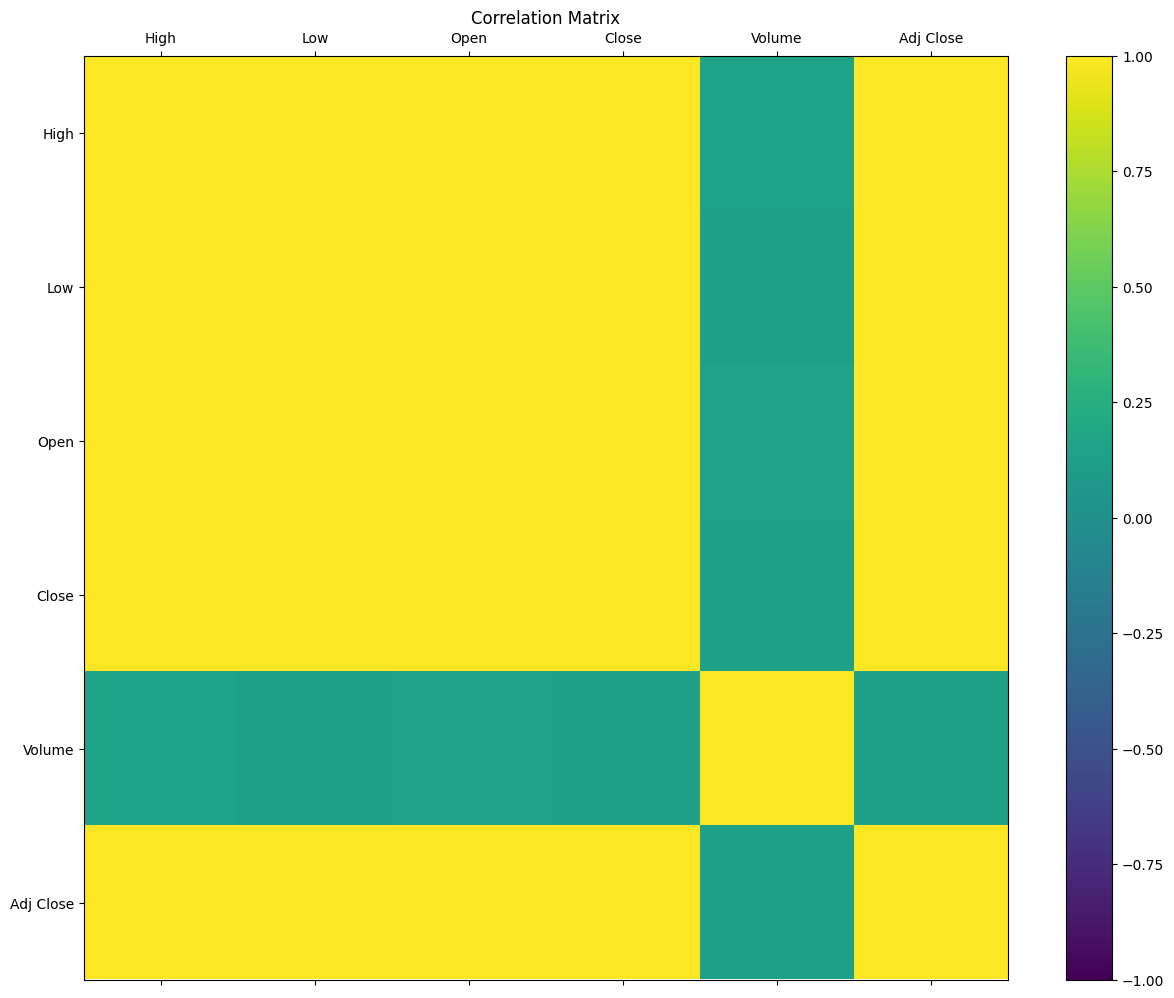

In [ ]:
# Example
get_values_correlation(amazon)

Here is our global function to use for our datasets exploration

In [22]:
def exploration(dataset):
    head_tail_40(dataset)

    get_number_of_observation(dataset)

    get_time_delta(dataset)

    get_statistics(dataset)

    get_values_correlation(dataset)

Head/tail 40 rows of the dataset AMAZON

The 40 first elements : 
+-------------------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+------------+
|               Date|             High|              Low|             Open|            Close|   Volume|        Adj Close|company_name|
+-------------------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+------------+
|2017-01-03 00:00:00| 758.760009765625|747.7000122070312|757.9199829101562|753.6699829101562|3521100.0|753.6699829101562|      AMAZON|
|2017-01-04 00:00:00|759.6799926757812|754.2000122070312|758.3900146484375|757.1799926757812|2510500.0|757.1799926757812|      AMAZON|
|2017-01-05 00:00:00|782.4000244140625| 760.260009765625|761.5499877929688|780.4500122070312|5830100.0|780.4500122070312|      AMAZON|
|2017-01-06 00:00:00|799.4400024414062|  778.47998046875|782.3599853515625| 795.989990234375|5986200.0| 795.989990234375|   

<ipython-input-18-a78df6bc5a0e>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+attr)
<ipython-input-18-a78df6bc5a0e>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+attr)


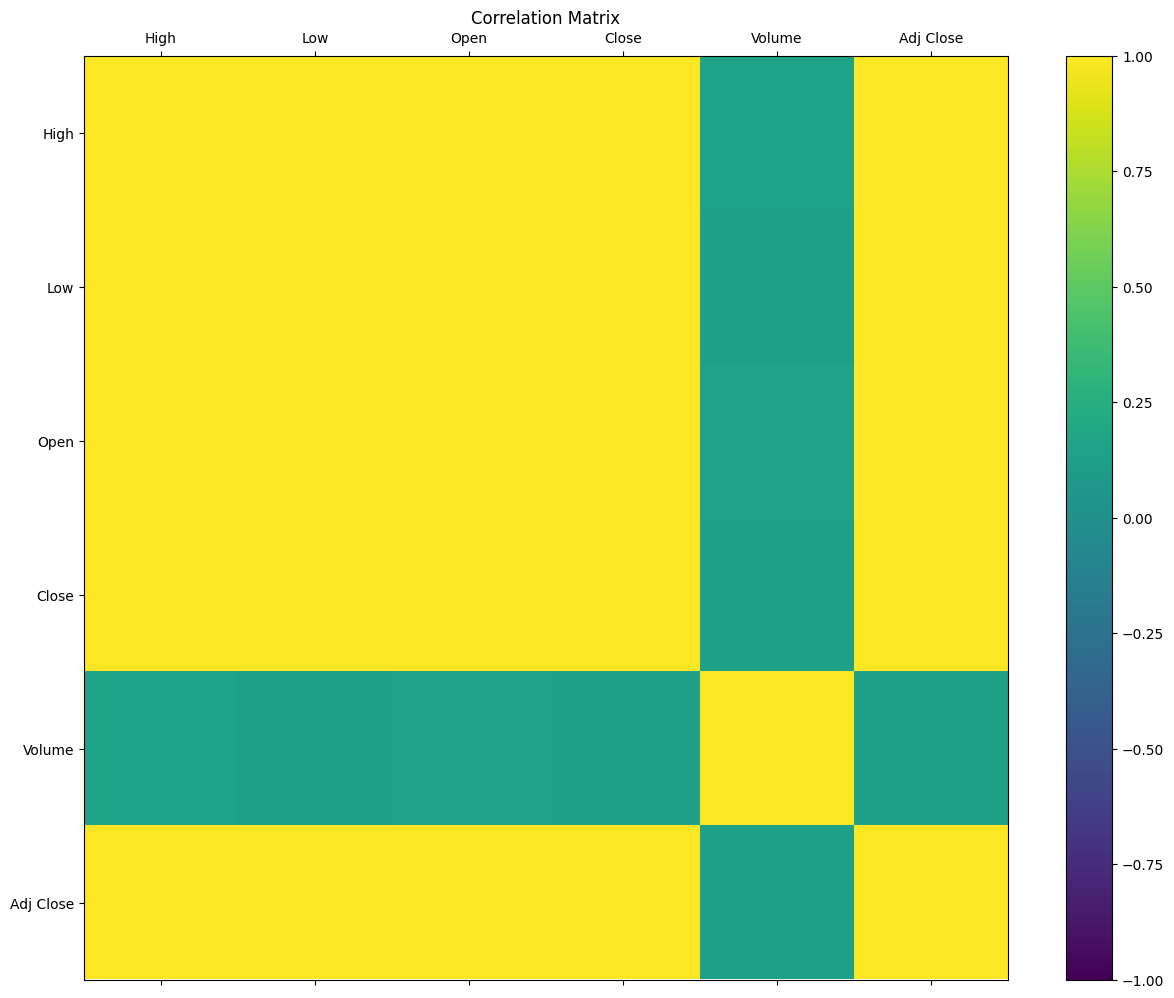

In [ ]:
# Example
exploration(amazon)

## Exploration of the datasets (part 2)

Computation of the average of the opening and closing prices for each stock price and for
different time periods (week, month, year)

Usage:
* `type` can be set to *week*, *month* or *year* to change the scale used for the average
* `beginDate` can be set to any date present in the dataset where the average computation will begin

In [23]:
def average_opening_closing(dataset, type=None, beginDate=None):
    if not beginDate:
        beginDate = dataset.head().Date
    if type == "week":
        dd = dataset.select('Open', 'Close').filter(dataset.Date < beginDate + timedelta(weeks=1))
    elif type == "month":
        dd = dataset.select('Open', 'Close').filter(dataset.Date < beginDate + timedelta(weeks=4))
    elif type == "year":
        dd = dataset.select('Open', 'Close').filter(dataset.Date < beginDate + timedelta(weeks=52))
    else:
        dd = dataset.select('Open', 'Close')
    dd = dd.withColumn('Result', abs(dataset['Close'] - dataset['Open']))
    dd.select((mean('Result'))).show()

In [ ]:
# Example
average_opening_closing(amazon, type="year", beginDate=amazon.head(50)[-1].Date)

+-----------------+
|      avg(Result)|
+-----------------+
|9.063970743815105|
+-----------------+



To study how the stock prices change day to day and month to month, we dediced
to represent *Open*, *High*, *Low* and *Close* column with a candlestick chart.

In [29]:
import plotly.graph_objects as go

def plot_prices_evolution(dataset):
    df = dataset.toPandas().sort_values(['Date'])

    fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])
    fig.update_xaxes(title_text="Date")
    fig.layout.update(title_text="Apple Candlestick plot")
    fig.update_yaxes(title_text="Price")

    fig.show()

In [25]:
# apple = apple.withColumn("Date", col("date").cast(TimestampType()))

# Define the date range
start_date = "2019-01-01"
end_date = "2020-12-02"

# Filter based on company names and date range
filtered_apple = apple.filter(
    (col("Date").between(lit(start_date), lit(end_date)))
)

In [26]:
# apple

In [30]:
# Example
plot_prices_evolution(filtered_apple)

/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:175: FutureWarning:

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead



Based on the opening and closing price, we compute the daily return of a stock.

In [33]:
def compute_daily_return(dataset):
    return dataset.withColumn('daily_return', dataset['Close'] - dataset['Open'])

In [ ]:
# Example
compute_daily_return(amazon).show()

+-------------------+------+------+------+------+---------+---------+------------+------------+
|               Date|  High|   Low|  Open| Close|   Volume|Adj Close|company_name|daily_return|
+-------------------+------+------+------+------+---------+---------+------------+------------+
|2017-01-03 00:00:00|758.76| 747.7|757.92|753.67|3521100.0|   753.67|      AMAZON|       -4.25|
|2017-01-04 00:00:00|759.68| 754.2|758.39|757.18|2510500.0|   757.18|      AMAZON|   -1.210022|
|2017-01-05 00:00:00| 782.4|760.26|761.55|780.45|5830100.0|   780.45|      AMAZON|   18.900024|
|2017-01-06 00:00:00|799.44|778.48|782.36|795.99|5986200.0|   795.99|      AMAZON|   13.630005|
|2017-01-09 00:00:00|801.77|791.77| 798.0|796.92|3446100.0|   796.92|      AMAZON|  -1.0800171|
|2017-01-10 00:00:00| 798.0|789.54| 796.6| 795.9|2558400.0|    795.9|      AMAZON|  -0.6999512|
|2017-01-11 00:00:00| 799.5|789.51|793.66|799.02|2992800.0|   799.02|      AMAZON|   5.3600464|
|2017-01-12 00:00:00|814.13| 799.5|800.3

Let's get the stocks with the highest **daily return** between our

1.   List item
2.   List item

datasets:

In [34]:
def get_max_daily_return(datasets):
    max_daily_return = []
    for dataset in datasets:
        name = dataset.head().company_name
        dd = compute_daily_return(dataset)
        max_daily_return.append((name, dd.select(max("daily_return")).collect()))
    return max_daily_return

In [35]:
max_daily_return = get_max_daily_return(datasets)
for name, max_dr in max_daily_return:
    print(f"{name} max daily return : {max_dr[0][0]}")

AMAZON max daily return : 196.64013671875
APPLE max daily return : 5.540000915527344
FACEBOOK max daily return : 19.910003662109375
GOOGLE max daily return : 61.8299560546875
MICROSOFT max daily return : 11.330001831054688
TESLA max daily return : 53.71002197265625
ZOOM max daily return : 34.470001220703125


In [40]:
from pyspark.sql.functions import col, max

# Assuming 'High' and 'Low' are the columns representing high and low values
max_return_per_stock = aggregated_stocks.groupBy("company_name").agg(
    max(col("High") - col("Low")).alias("max_return")
)

max_return_per_stock.show()

+------------+----------+
|company_name|max_return|
+------------+----------+
|   MICROSOFT| 21.180008|
|       APPLE| 12.809998|
|    FACEBOOK| 20.670013|
|       TESLA|  73.92001|
|      GOOGLE|102.617065|
|      AMAZON| 275.90015|
|        ZOOM|  67.32001|
+------------+----------+



In [46]:
max_return_per_stock.toPandas().to_csv('us1.csv')

Computation of the average of the daily_return of a stock for
different time periods (week, month, year)

Usage:
* `type` can be set to *week*, *month* or *year* to change the scale used for the average
* `beginDate` can be set to any date present in the dataset where the average computation will begin

In [ ]:
def average_daily_return(dataset, type=None, beginDate=None):
    dd = compute_daily_return(dataset)
    if not beginDate:
        beginDate = dd.head().Date
    if type == "week":
        dd = dd.select('daily_return').filter(dd.Date < beginDate + timedelta(weeks=1))
    elif type == "month":
        dd = dd.select('daily_return').filter(dd.Date < beginDate + timedelta(weeks=4))
    elif type == "year":
        dd = dd.select('daily_return').filter(dd.Date < beginDate + timedelta(weeks=52))
    else:
        dd = dd.select('daily_return')
    dd.select((mean('daily_return'))).show()

In [ ]:
# Example
average_daily_return(amazon, type="year")

+--------------------+
|   avg(daily_return)|
+--------------------+
|-0.10860731877178785|
+--------------------+



## Moving average

The moving average is calculated by adding a stock's prices over a certain
period and dividing the sum by the total number of periods.

In [64]:
def moving_average(dataset, column_name, nb_points):
    days = lambda i: i * 86400
    w = (Window.orderBy(col("date").cast("timestamp").cast('long')).rangeBetween(-days(nb_points), 0))
    print(w)
    return dataset.withColumn('moving_average', avg(column_name).over(w))

In [66]:
start_date = "2019-01-01"
end_date = "2020-12-02"

# Filter based on company names and date range
filtered_apple = apple.filter(
    (col("Date").between(lit(start_date), lit(end_date)))
)

In [69]:
apple_ma = moving_average(filtered_apple, 'Open', 10)

/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:175: FutureWarning:

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead



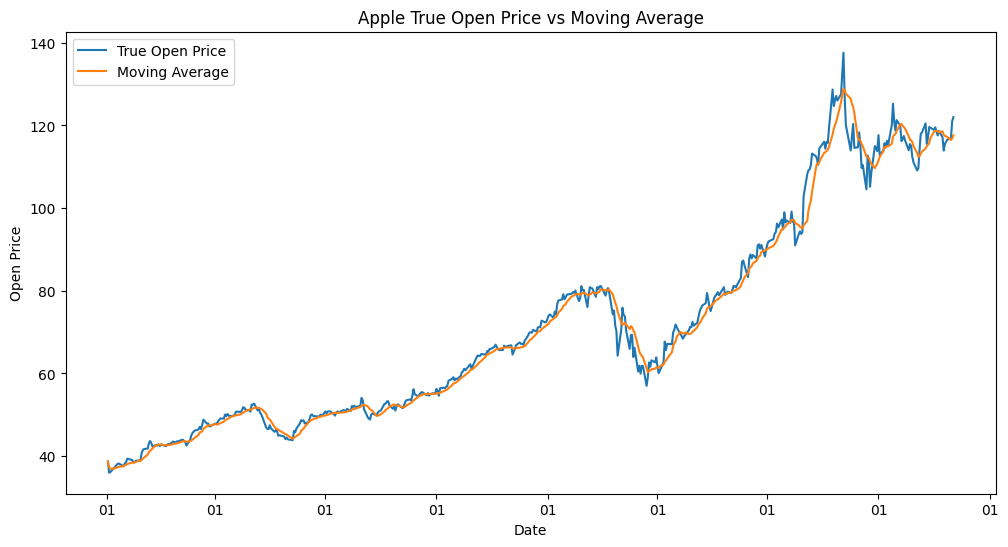

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter


# Assuming 'date', 'Open', and 'moving_average' are columns in your DataFrame

# Convert to Pandas DataFrame for easier plotting
apple_ma = apple_ma.select('date', 'Open', 'moving_average').toPandas()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(apple_ma['date'], apple_ma['Open'], label='True Open Price')
plt.plot(apple_ma['date'], apple_ma['moving_average'], label='Moving Average')
plt.title('Apple True Open Price vs Moving Average')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
date_format = DateFormatter("%d")
plt.gca().xaxis.set_major_formatter(date_format)

plt.show()
plt.show()


## Correlation between datasets

In [48]:
def correlation_two_datasets(stock1, stock2):
    stock_renamed = stock2.select([col(c).alias(c+str(2)) for c in stock2.columns])
    merged = stock1.join(stock_renamed, stock1.Date == stock_renamed.Date2, "left_outer")
    print(f"Correlation between {stock1.head().company_name} and {stock2.head().company_name}:")
    print("Correlation between Open column  : ", round(merged.corr("Open", "Open2") * 100, 2), "%")
    print("Correlation between Close column : ", round(merged.corr("Close", "Close2") * 100, 2), "%")
    print("Correlation between High column  : ", round(merged.corr("High", "High2") * 100, 2), "%")
    print("Correlation between Low column   : ", round(merged.corr("Low", "Low2") * 100, 2), "%")
    print("Correlation between Volume column: ", round(merged.corr("Volume", "Volume2") * 100, 2), "%")

In [ ]:
correlation_two_datasets(amazon, apple)

Correlation between AMAZON and APPLE:
Correlation between Open column  :  92.94 %
Correlation between Close column :  92.93 %
Correlation between High column  :  92.98 %
Correlation between Low column   :  92.95 %
Correlation between Volume column:  53.4 %


In [49]:
correlation_two_datasets(zoom, apple)

Correlation between ZOOM and APPLE:
Correlation between Open column  :  87.94 %
Correlation between Close column :  87.99 %
Correlation between High column  :  88.09 %
Correlation between Low column   :  87.84 %
Correlation between Volume column:  29.71 %


In [ ]:
def get_datasets_merged(datasets):
    suffix = 0
    res = datasets[0].select("*")
    res = res.select([col(c).alias(c+str(suffix)) for c in res.columns])
    suffix += 1
    for i in range(len(datasets) -1):
        stock_renamed =  datasets[i+1].select([col(c).alias(c+str(suffix)) for c in datasets[i+1].columns])
        res = res.join(stock_renamed, res.Date0 == stock_renamed["Date" + str(suffix)], how="left_outer")
        suffix += 1
    return res

In [ ]:
# Example
get_datasets_merged(datasets).show()

+-------------------+------+------+------+------+---------+----------+-------------+-------------------+-------+-------+-------+-------+----------+----------+-------------+-------------------+------+------+------+------+---------+----------+-------------+-------------------+-------+-------+------+-------+---------+----------+-------------+-------------------+-----+-----+-----+------+---------+----------+-------------+-------------------+------+------+------+------+---------+----------+-------------+-----+-----+----+-----+------+-------+----------+-------------+
|              Date0| High0|  Low0| Open0|Close0|  Volume0|Adj Close0|company_name0|              Date1|  High1|   Low1|  Open1| Close1|   Volume1|Adj Close1|company_name1|              Date2| High2|  Low2| Open2|Close2|  Volume2|Adj Close2|company_name2|              Date3|  High3|   Low3| Open3| Close3|  Volume3|Adj Close3|company_name3|              Date4|High4| Low4|Open4|Close4|  Volume4|Adj Close4|company_name4|           

In [ ]:
# Correlation matrix plot function
def plot_corr_matrix_column(fig, ax, correlations, attr, column_name):
    mat = ax.matshow(correlations, vmax=1, vmin=-1)
    ax.set_xticks(range(len(attr)), attr, rotation=45)
    ax.set_yticks(range(len(attr)), attr )
    ax.set_title(f"{column_name}");
    return mat

In [ ]:
def datasets_correlation(datasets):
    column_names = [column[0] for column in datasets[0].dtypes if column[1] == "float"]
    merged = get_datasets_merged(datasets)
    matrix = np.zeros(shape=(len(datasets), len(datasets)))
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle("Correlation Matrix", fontsize=20)
    for k, ax in enumerate(axes.flat):
        for i in range(len(datasets)):
            for j in range(len(datasets)):
                matrix[i][j] = merged.corr(column_names[k] + str(i), column_names[k] + str(j))
        mat = plot_corr_matrix_column(fig, ax, matrix, [dataset.head().company_name for dataset in datasets], column_names[k])
    plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.8,
                    hspace=0.2)
    fig.colorbar(mat, ax=axes)

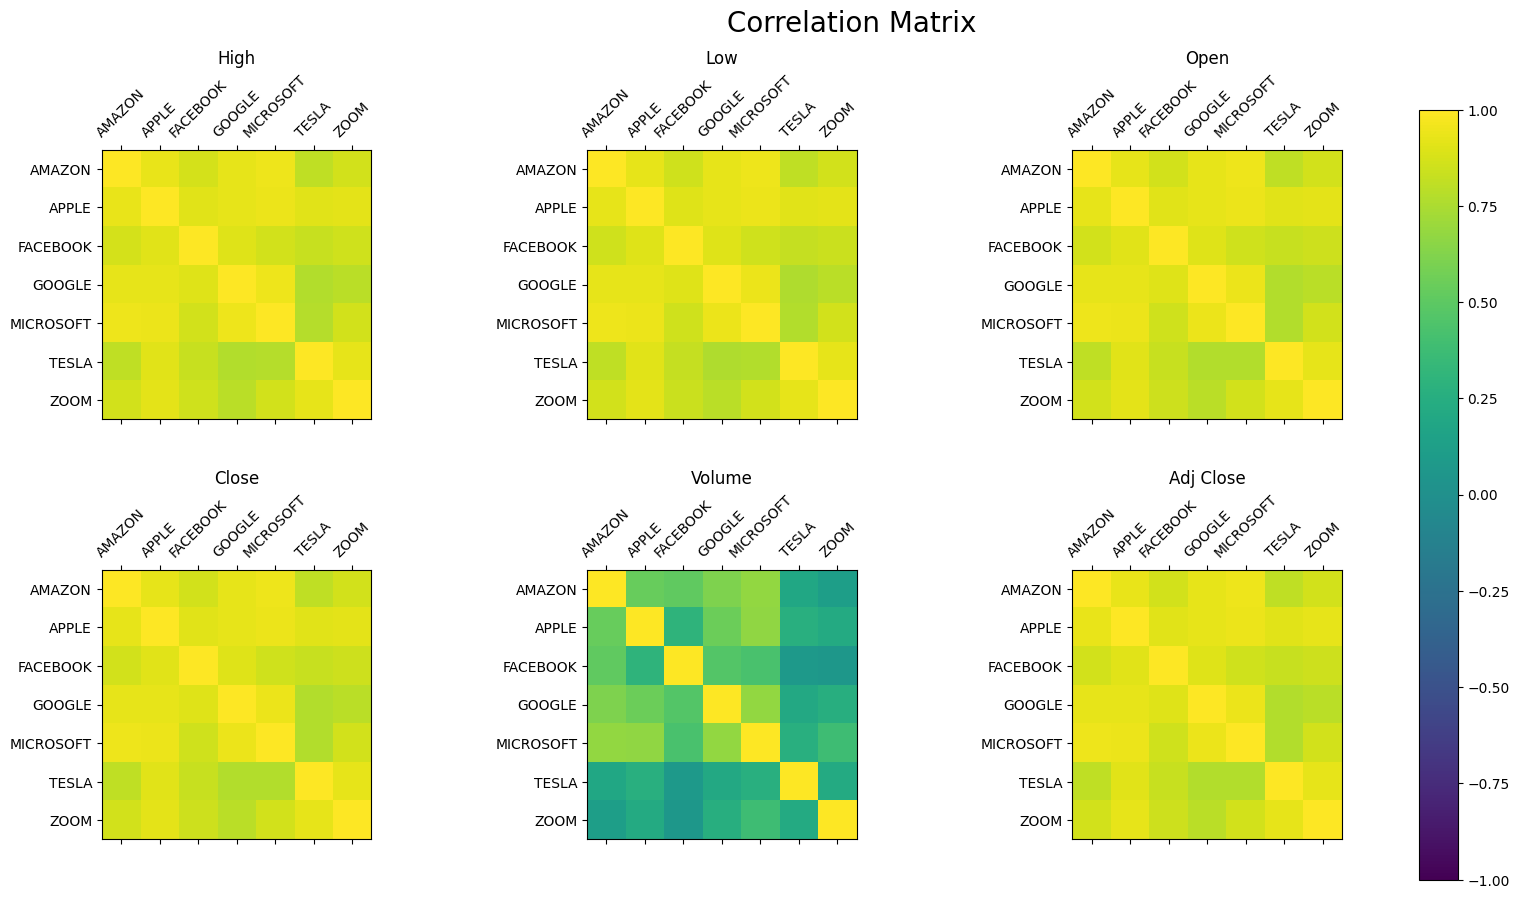

In [ ]:
datasets_correlation(datasets)

In [ ]:
def get_return_rate_specific_date(dataset, timedelta, date):
    initial_value = dataset.select(['date', 'Close']).filter(dataset.Date == date - timedelta).first()
    current_value = dataset.select(['date', 'Close']).filter(dataset.Date == date).first()
    return ((current_value.Close - initial_value.Close) / initial_value.Close) * 100 if initial_value else None

In [ ]:
get_return_rate_specific_date(amazon, timedelta(weeks=4), amazon.head(50)[-1].Date)

1.2186968490954129

In [ ]:
def get_return_rate(dataset, cat="week"):
    if cat == "week":
        sample = 'W'
    elif cat == "month":
        sample = 'M'
    elif cat == "year":
        sample = 'Y'
    elif cat == "day":
        sample = 'D'
    df = dataset.toPandas()
    df.set_index("Date", inplace=True)
    return df['Adj Close'].resample(sample).ffill().pct_change()

In [ ]:
get_return_rate(amazon, 'month')

/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:175: FutureWarning:

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead



Date
2017-01-31         NaN
2017-02-28    0.026182
2017-03-31    0.049110
2017-04-30    0.043371
2017-05-31    0.075276
2017-06-30   -0.026764
2017-07-31    0.020434
2017-08-31   -0.007269
2017-09-30   -0.019631
2017-10-31    0.149717
2017-11-30    0.064662
2017-12-31   -0.006187
2018-01-31    0.240639
2018-02-28    0.042429
2018-03-31   -0.043049
2018-04-30    0.082075
2018-05-31    0.040539
2018-06-30    0.043065
2018-07-31    0.045676
2018-08-31    0.132365
2018-09-30   -0.004824
2018-10-31   -0.202192
2018-11-30    0.057672
2018-12-31   -0.111350
2019-01-31    0.144317
2019-02-28   -0.045906
2019-03-31    0.085936
2019-04-30    0.081859
2019-05-31   -0.078613
2019-06-30    0.066792
2019-07-31   -0.014179
2019-08-31   -0.048474
2019-09-30   -0.022733
2019-10-31    0.023475
2019-11-30    0.013587
2019-12-31    0.026122
2020-01-31    0.087064
2020-02-29   -0.062214
2020-03-31    0.035021
2020-04-30    0.268900
2020-05-31   -0.012785
2020-06-30    0.129567
2020-07-31    0.147114
2020-0

In [ ]:
def get_best_return_rate(datasets, start_date, cat="month"):
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    if cat == "month":
        t_delta = timedelta(weeks=4)
    elif cat == "year":
        t_delta = timedelta(weeks=52)
    max_return_rate = None
    for dataset in datasets:
        return_rate = get_return_rate_specific_date(dataset, t_delta, start_date)
        if return_rate and (not max_return_rate or return_rate > max_return_rate[1]):
            max_return_rate = (dataset.head().company_name, return_rate)
    if max_return_rate:
        print(f"Max return is from {max_return_rate[0]} : {max_return_rate[1]}")
    return max_return_rate


In [ ]:
get_best_return_rate(datasets, "2017-02-14", 'month')

Max return is from TESLA : 19.27158035222068


('TESLA', 19.27158035222068)

## Insights

### 1 - Price data

Close price evolution for each stocks depending on the date.

In [51]:
def plot_price_data(dataset):
    fig = plt.figure(figsize=(15, 5))
    for dataset in datasets:
        start_date = "2019-01-01"
        end_date = "2020-12-02"

        # Filter based on company names and date range
        dataset = dataset.filter(
            (col("Date").between(lit(start_date), lit(end_date)))
        )


        df_daily = dataset.toPandas().sort_values(['Date'])
        df_daily.set_index('Date', inplace=True)

        df_daily['Close'].plot(label=dataset.head().company_name)

    plt.gcf().autofmt_xdate()
    plt.legend()

/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:175: FutureWarning:

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead

/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:175: FutureWarning:

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead

/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:175: FutureWarning:

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead

/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:175: FutureWarning:

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead

/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:175: FutureWarning:

Passing unit

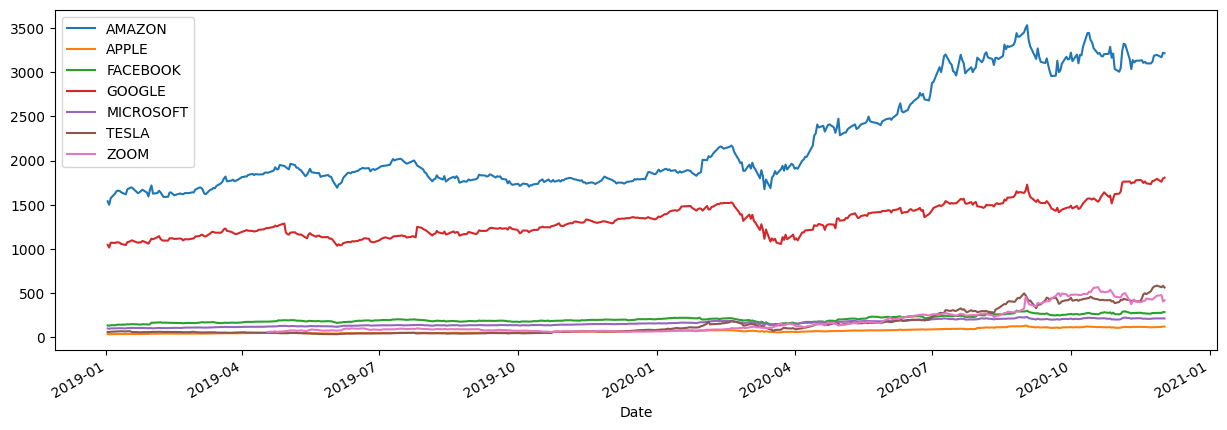

In [52]:
plot_price_data(datasets)

In [55]:
def return_percentage(datasets):

    fig = plt.figure(figsize=(15, 5))
    for dataset in datasets:
        start_date = "2019-01-01"
        end_date = "2020-12-02"

        # Filter based on company names and date range
        dataset = dataset.filter(
            (col("Date").between(lit(start_date), lit(end_date)))
        )

        df_daily = dataset.toPandas().sort_values(['Date'])
        df_daily.set_index('Date', inplace=True)
        stock_daily_returns = df_daily['Close'].pct_change()

        (stock_daily_returns + 1).cumprod().plot(label=dataset.head().company_name)

    plt.gcf().autofmt_xdate()
    plt.legend()

/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:175: FutureWarning:

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead

/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:175: FutureWarning:

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead

/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:175: FutureWarning:

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead

/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:175: FutureWarning:

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead

/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:175: FutureWarning:

Passing unit

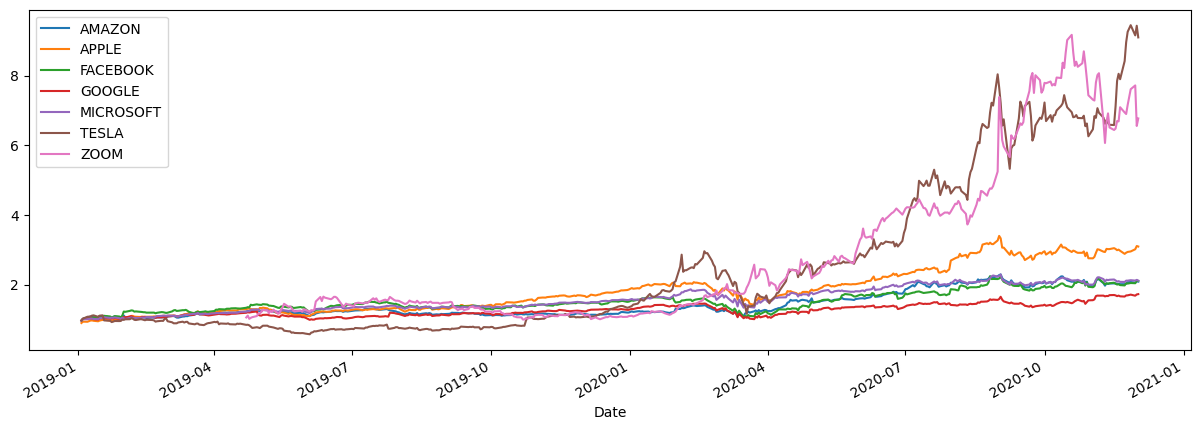

In [56]:
return_percentage(datasets)